In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn  import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns

random.seed(1)

df = pd.read_csv('Datasets_Zrive/feature_frame.csv')
df = df.drop(['created_at'], axis=1)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 26 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   order_date                        object 
 5   user_order_seq                    int64  
 6   outcome                           float64
 7   ordered_before                    float64
 8   abandoned_before                  float64
 9   active_snoozed                    float64
 10  set_as_regular                    float64
 11  normalised_price                  float64
 12  discount_pct                      float64
 13  vendor                            object 
 14  global_popularity                 float64
 15  count_adults                      float64
 16  count_children                    fl

In [3]:
print(len(df.vendor.value_counts()))
print(len(df.product_type.value_counts()))

264
62


In [4]:
vendor_value_counts = df.vendor.value_counts()
product_type_counts = df.product_type.value_counts()

df['vendor'] = df['vendor'].apply(lambda x: vendor_value_counts[x]).astype('int32')
df['product_type'] = df['product_type'].apply(lambda x: product_type_counts[x]).astype('int32')


In [5]:
df['outcome'] = df['outcome'].astype('int8')
df['order_date'] = pd.to_datetime(df['order_date'])
conversion_factor = 1e-9
df['order_date'] = df['order_date'].astype('int64').astype('float64') * conversion_factor
len(df)

2880549

In [6]:
new_order = df.columns.to_list()
new_order.remove('outcome')
new_order.remove('product_type')
new_order = ['outcome'] + new_order[:3] + ['product_type'] + new_order[3:]
df = df[new_order]
df.head()

,outcome,variant_id,order_id,user_id,product_type,order_date,user_order_seq,ordered_before,abandoned_before,active_snoozed,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,0,33826472919172,2807985930372,3482464092292,128098,1.601856e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,0,33826472919172,2808027644036,3466586718340,128098,1.601856e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,0,33826472919172,2808099078276,3481384026244,128098,1.601856e+09,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,0,33826472919172,2808393957508,3291363377284,128098,1.601942e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,0,33826472919172,2808429314180,3537167515780,128098,1.601942e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [7]:
df_orders = df.groupby(by='order_id')['outcome'].sum()
print(len(df_orders))
transac_5_items = df_orders[df_orders>5].index.to_list()

df_clean = df[df['order_id'].isin(transac_5_items)]

3446


In [8]:

random.shuffle(transac_5_items)

train_data_orders =  transac_5_items[:int(len(transac_5_items)*0.7)]
val_data_orders = transac_5_items[int(len(transac_5_items)*0.7):int(len(transac_5_items)*0.9)]
test_data_orders = transac_5_items[int(len(transac_5_items)*0.9):]

In [9]:
train_data_x = df[df['order_id'].isin(train_data_orders)].iloc[:,4:]
train_data_y = df[df['order_id'].isin(train_data_orders)].iloc[:,0]
val_data_x = df[df['order_id'].isin(val_data_orders)].iloc[:,4:]
val_data_y = df[df['order_id'].isin(val_data_orders)].iloc[:,0]
test_data_x = df[df['order_id'].isin(test_data_orders)].iloc[:,4:]
test_data_y = df[df['order_id'].isin(test_data_orders)].iloc[:,0]

In [18]:

log_model = LogisticRegression(penalty= None, n_jobs=-1, class_weight='balanced')

log_model.fit(train_data_x,train_data_y)

y_pred = log_model.predict(val_data_x)
y_pred_prob = log_model.predict_proba(val_data_x)[:,1]

metrics.accuracy_score(val_data_y, y_pred)

0.9853157520586087

0.5250280455551812


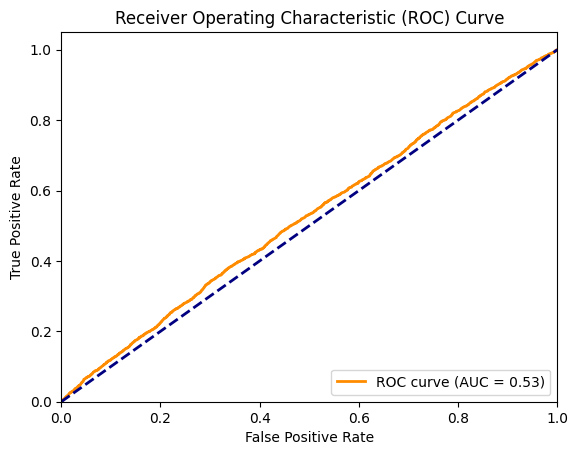

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(val_data_y, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
metrics.confusion_matrix(val_data_y, y_pred)

array([[399179,      0],
       [  5949,      0]])

In [13]:
param_grid = {
    'C': [10 ** i for i in range(-4,2)],
    'penalty': ['l2']
}

log_model_l1 = LogisticRegression(solver='lbfgs',n_jobs=-1, class_weight='balanced')

grid_search_l1 = GridSearchCV(log_model_l1, param_grid, cv=5, scoring='accuracy').fit(train_data_x,train_data_y)

print(grid_search_l1.best_params_)

y_pred_prob_l1 = grid_search_l1.predict_proba(val_data_x)[:,1]
y_pred = grid_search_l1.predict(val_data_x)

metrics.accuracy_score(val_data_y, y_pred)

{'C': 0.0001, 'penalty': 'l2'}


0.9853157520586087

0.5250279457537681


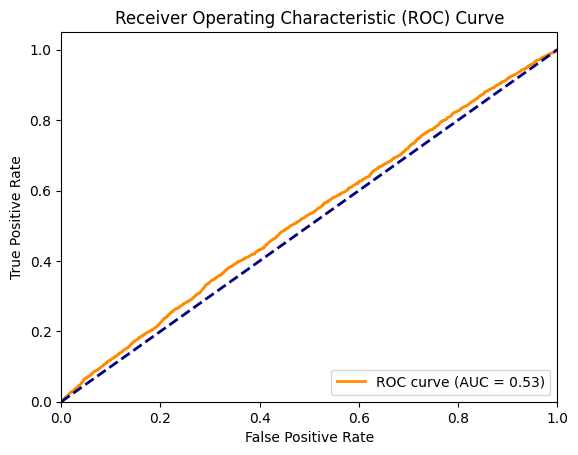

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(val_data_y, y_pred_prob_l1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
conf_matrix_l1 = metrics.confusion_matrix(val_data_y, y_pred)
conf_matrix_l1

array([[399179,      0],
       [  5949,      0]])

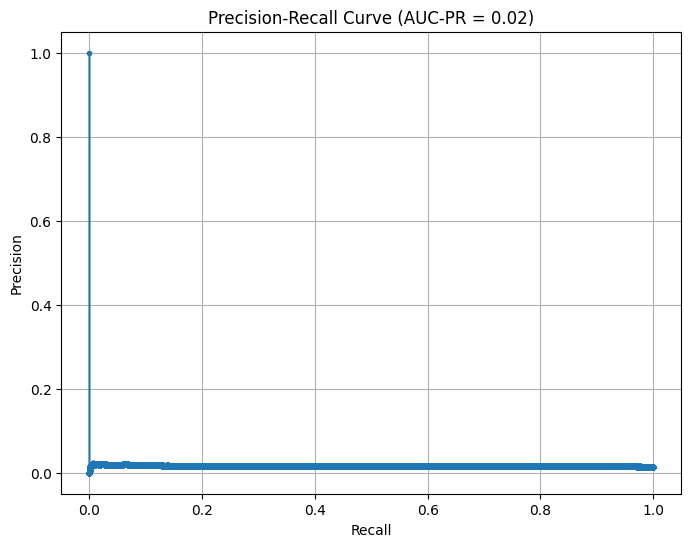

In [26]:
precision, recall, thresholds = precision_recall_curve(val_data_y, y_pred_prob_l1)

# Calculate the area under the precision-recall curve (AUC-PR)
average_precision = average_precision_score(val_data_y, y_pred_prob_l1)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AUC-PR = {:.2f})'.format(average_precision))
plt.grid()
plt.show()

In [31]:
from sklearn.utils import resample

train_data = df[df['order_id'].isin(train_data_orders)]
majority_class = train_data[train_data['outcome'] == 0]
minority_class = train_data[train_data['outcome'] == 1]

majority_class_undersampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the minority class with the undersampled majority class
balanced_df = pd.concat([majority_class_undersampled, minority_class])

balanced_df

,outcome,variant_id,order_id,user_id,product_type,order_date,user_order_seq,ordered_before,abandoned_before,active_snoozed,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
591213,0,33667282075780,2861168459908,3815052968068,31593,1.606867e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,36.0,28.786199,27.0,30.0,24.688701
1100617,0,34086450987140,2887443120260,3874925314180,51266,1.609632e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,54.0,34.910030,30.0,36.0,28.268085
2007369,0,33667185016964,2885305139332,3745761755268,54442,1.609286e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,37.0,20.293677,30.0,36.0,29.372186
2600832,0,34284953796740,2920192966788,3898440056964,45381,1.613088e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,37.5,30.297336,30.0,24.0,26.048133
1096726,0,34137389105284,2868033257604,3766058123396,114978,1.607472e+09,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,45.0,29.815304,30.0,32.0,28.189363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860233,1,34304342851716,2827489443972,3765099954308,10120,1.603930e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,47.0,31.017468,30.0,39.0,35.641908
2860234,1,34304342851716,2827551244420,3513667223684,10120,1.603930e+09,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,47.0,31.017468,30.0,39.0,35.641908
2860261,1,34304342851716,2829221494916,3784403714180,10120,1.604102e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,47.0,31.017468,30.0,39.0,35.641908
2863549,1,33826433859716,2823601127556,3469897564292,20585,1.603411e+09,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,82.0,44.243644,30.0,38.5,31.832738


In [34]:
balanced_train_data_x = df[df['order_id'].isin(train_data_orders)].iloc[:,4:]
balanced_train_data_y = df[df['order_id'].isin(train_data_orders)].iloc[:,0]

param_grid = {
    'C': [10 ** i for i in range(-4,2)],
    'penalty': ['l2']
}

log_model_l1 = LogisticRegression(solver='lbfgs',n_jobs=-1, class_weight='balanced')

grid_search_l1 = GridSearchCV(log_model_l1, param_grid, cv=5, scoring='accuracy').fit(balanced_train_data_x,balanced_train_data_y)

print(grid_search_l1.best_params_)

y_pred_prob_l1 = grid_search_l1.predict_proba(val_data_x)[:,1]
y_pred = grid_search_l1.predict(val_data_x)

metrics.accuracy_score(val_data_y, y_pred)

{'C': 0.0001, 'penalty': 'l2'}


0.9853157520586087

0.5250279457537681


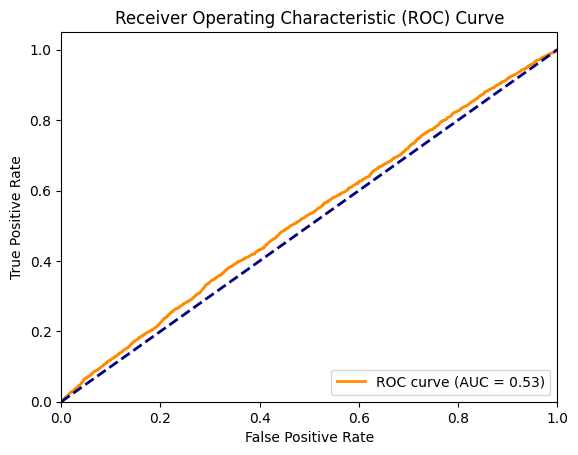

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(val_data_y, y_pred_prob_l1)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [36]:
conf_matrix_l1 = metrics.confusion_matrix(val_data_y, y_pred)
conf_matrix_l1

array([[399179,      0],
       [  5949,      0]])

In [38]:
grid_search_l1.cv_results_

{'mean_fit_time': array([1.7880784 , 1.44479442, 1.30935836, 1.92762914, 2.01452518,
        1.96853099]),
 'std_fit_time': array([0.3449785 , 0.43726335, 0.54229414, 0.13242939, 0.04739983,
        0.02130528]),
 'mean_score_time': array([0.03463025, 0.03144879, 0.03171158, 0.0383934 , 0.04381466,
        0.03930693]),
 'std_score_time': array([0.00667459, 0.00539753, 0.00731328, 0.00436032, 0.00527543,
        0.00444767]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l2', 'l2', 'l2', 'l2', 'l2', 'l2'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001, 'penalty': 'l2'},
  {'C': 0.001, 'penalty': 'l2'},
  {'C': 0.01, 'penalty': 'l2'},
  {'C': 0.1, 'penalty': 'l2'},
  {'C': 1, 'penalty': 'l2'},
  {'C': 10, 'penalty': 'l2'}],
 

In [40]:
y_pred_prob_l1.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'